In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# === Load Data ===
file_path = "C:/Users/adaml/Downloads/Time Table for Social Science Project.xlsx"

# Load sheets
df_results = pd.read_excel(file_path, sheet_name="results-ChatGPT")
df_personas = pd.read_excel(file_path, sheet_name="Personas")
df_questions = pd.read_excel(file_path, sheet_name="Qestions")


In [3]:
# === Clean Column Names ===
df_results.columns = df_results.columns.str.strip().str.lower().str.replace(' ', '_')
df_personas.columns = df_personas.columns.str.strip().str.lower().str.replace(' ', '_')
df_questions.columns = df_questions.columns.str.strip().str.lower().str.replace(' ', '_')

# === Parse annotator votes ===
df_results[['ann1', 'ann2', 'ann3']] = df_results["classification_-_don't_fill_now"].astype(str).str.split(';', expand=True)
df_results[['ann1', 'ann2', 'ann3']] = df_results[['ann1', 'ann2', 'ann3']].apply(pd.to_numeric, errors='coerce')

# === Compute majority vote: 2 out of 3 annotators agree ===
df_results['answer'] = (df_results[['ann1', 'ann2', 'ann3']].sum(axis=1) >= 2).astype(int)

# === Drop incomplete entries ===
df_clean = df_results.dropna(subset=['answer'])

# === Merge in religion and solidarity group ===
df_merged = df_clean.merge(df_personas[['id', 'religion']], left_on='persona_id', right_on='id', how='left')
df_merged = df_merged.merge(df_questions[['id', 'solidarity_group']], left_on='question_id', right_on='id', how='left', suffixes=('', '_q'))
df_merged = df_merged.dropna(subset=['solidarity_group'])

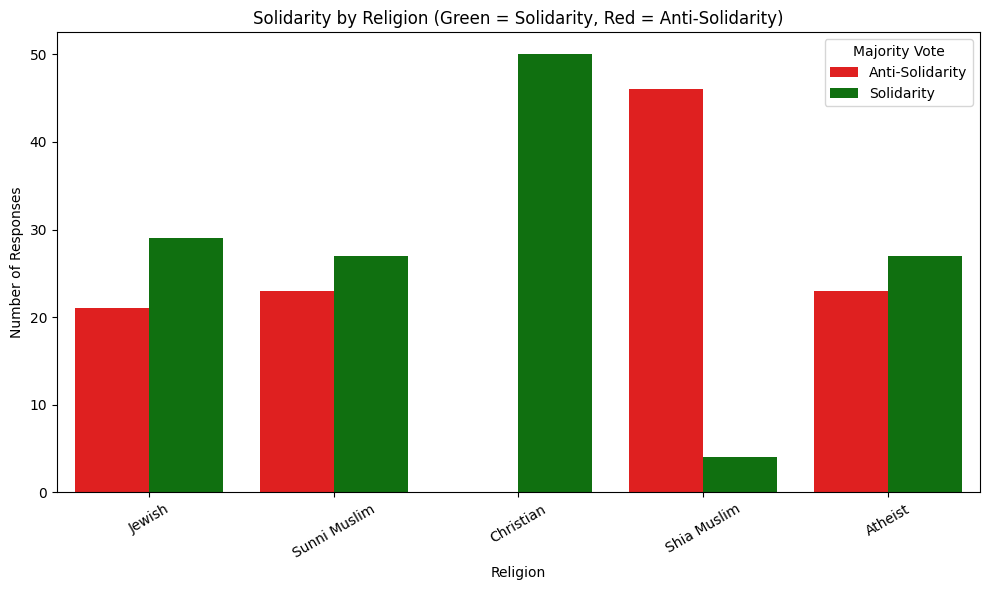

In [4]:
# === Plot 1: Raw Counts by Religion ===
plt.figure(figsize=(10, 6))
sns.countplot(
    data=df_merged,
    x='religion',
    hue='answer',
    palette={0: 'red', 1: 'green'}
)
plt.title("Solidarity by Religion (Green = Solidarity, Red = Anti-Solidarity)")
plt.xlabel("Religion")
plt.ylabel("Number of Responses")
plt.legend(title="Majority Vote", labels=["Anti-Solidarity", "Solidarity"])
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

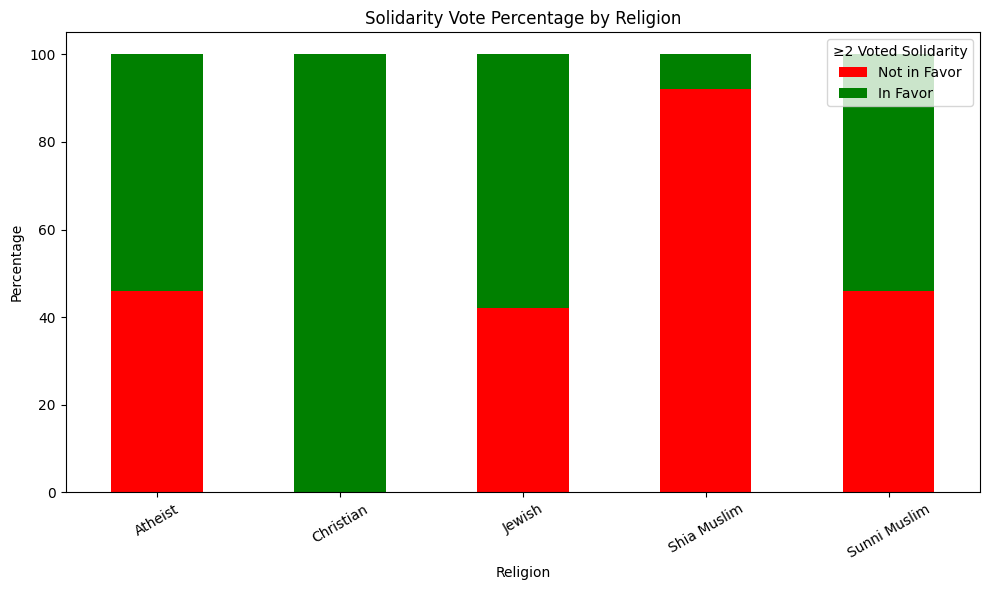

In [5]:
# === Plot 2: Percentage by Religion ===
# Convert 'answer' to boolean for grouping
df_merged['answer'] = df_merged['answer'].astype(bool)

# Compute normalized percentage
religion_summary = df_merged.groupby(['religion', 'answer']).size().unstack(fill_value=0)
religion_percent = religion_summary.div(religion_summary.sum(axis=1), axis=0) * 100

# Plot percentage chart
religion_percent.plot(
    kind='bar',
    stacked=True,
    color={False: 'red', True: 'green'},
    figsize=(10, 6)
)
plt.title("Solidarity Vote Percentage by Religion")
plt.xlabel("Religion")
plt.ylabel("Percentage")
plt.legend(title="≥2 Voted Solidarity", labels=["Not in Favor", "In Favor"])
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

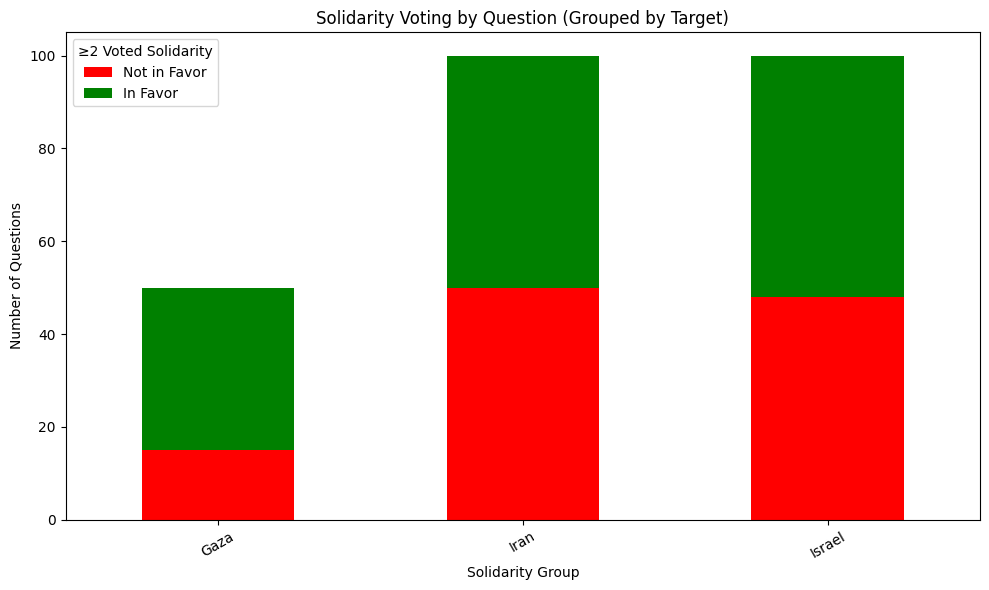

In [10]:
# === Plot 3 & 4: Solidarity by Target Group (using precomputed 'answer') ===
df_grouped = df_clean.merge(
    df_questions[['id', 'solidarity_group']],
    left_on='question_id',
    right_on='id',
    how='left',
    suffixes=('', '_q')
).dropna(subset=['solidarity_group'])

df_grouped['in_favor'] = df_grouped['answer'].astype(bool)

group_summary = df_grouped.groupby(['solidarity_group', 'in_favor']).size().unstack(fill_value=0)
group_summary.index = group_summary.index.str.strip().str.capitalize()

# Plot 3: Raw counts by group
group_summary.plot(kind='bar', stacked=True, color={True: 'green', False: 'red'}, figsize=(10, 6))
plt.title("Solidarity Voting by Question (Grouped by Target)")
plt.xlabel("Solidarity Group")
plt.ylabel("Number of Questions")
plt.legend(title="≥2 Voted Solidarity", labels=["Not in Favor", "In Favor"])
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

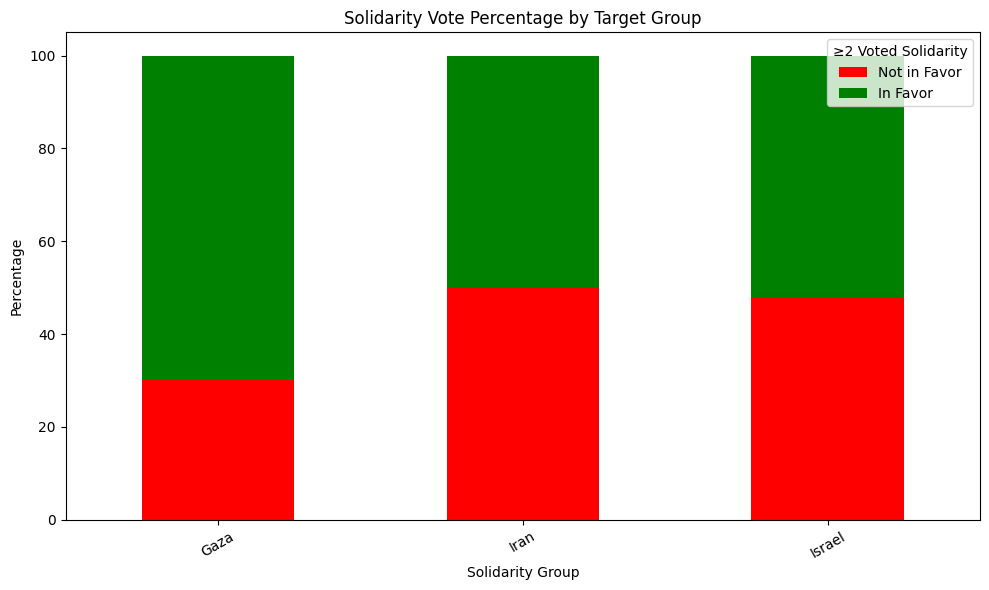

In [11]:
# Plot 4: Percentage by group
group_percent = group_summary.div(group_summary.sum(axis=1), axis=0) * 100
group_percent.plot(kind='bar', stacked=True, color={True: 'green', False: 'red'}, figsize=(10, 6))
plt.title("Solidarity Vote Percentage by Target Group")
plt.xlabel("Solidarity Group")
plt.ylabel("Percentage")
plt.legend(title="≥2 Voted Solidarity", labels=["Not in Favor", "In Favor"])
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

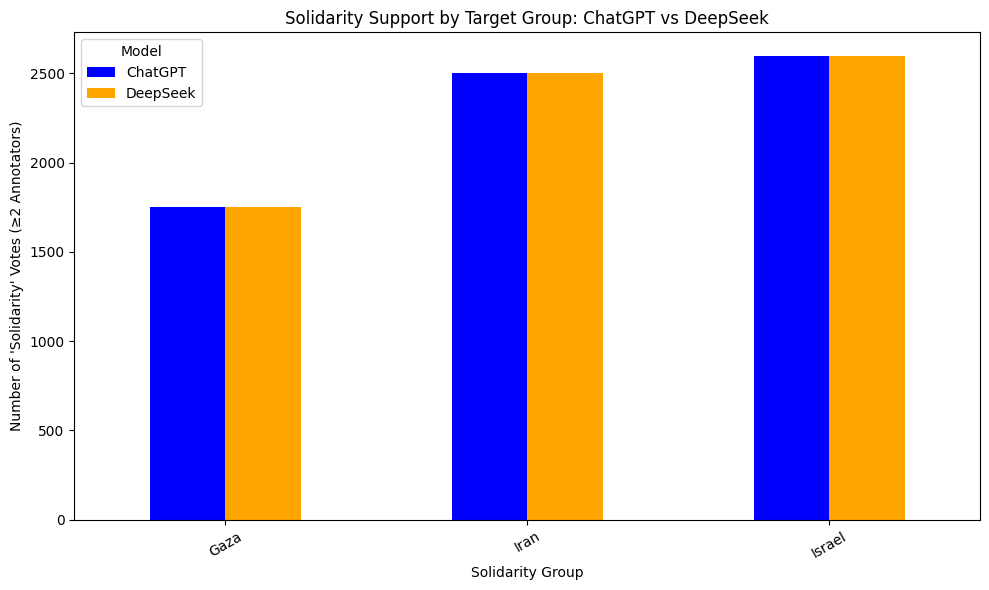

In [12]:
# === Load DeepSeek results ===
df_deepseek = pd.read_excel(file_path, sheet_name="results-Deepseek")
df_deepseek.columns = df_deepseek.columns.str.strip().str.lower().str.replace(' ', '_')

# === Parse and compute majority vote for DeepSeek ===
split_votes = df_deepseek["classification_-_don't_fill_now"].astype(str).str.split(';', expand=True)

# Pad to ensure 3 columns
for i in range(3 - split_votes.shape[1]):
    split_votes[i + split_votes.shape[1]] = None

split_votes = split_votes.iloc[:, :3]
split_votes.columns = ['ann1', 'ann2', 'ann3']
split_votes = split_votes.apply(pd.to_numeric, errors='coerce')

df_deepseek[['ann1', 'ann2', 'ann3']] = split_votes
df_deepseek['answer_deepseek'] = (split_votes.sum(axis=1) >= 2).astype(int)

# === Prepare ChatGPT vote if not already done ===
df_results['answer_chatgpt'] = (df_results[['ann1', 'ann2', 'ann3']].sum(axis=1) >= 2).astype(int)

# === Merge both results on question_id ===
df_compare = df_results[['question_id', 'answer_chatgpt']].merge(
    df_deepseek[['question_id', 'answer_deepseek']],
    on='question_id',
    how='inner'
)

# === Merge in solidarity group ===
df_compare = df_compare.merge(
    df_questions[['id', 'solidarity_group']],
    left_on='question_id',
    right_on='id',
    how='left'
).dropna(subset=['solidarity_group'])

# === Chart 1: Solidarity only ===
solidarity_plot = df_compare.groupby('solidarity_group')[['answer_chatgpt', 'answer_deepseek']].sum()
solidarity_plot.plot(kind='bar', figsize=(10, 6), color=['blue', 'orange'])
plt.title("Solidarity Support by Target Group: ChatGPT vs DeepSeek")
plt.xlabel("Solidarity Group")
plt.ylabel("Number of 'Solidarity' Votes (≥2 Annotators)")
plt.legend(["ChatGPT", "DeepSeek"], title="Model")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


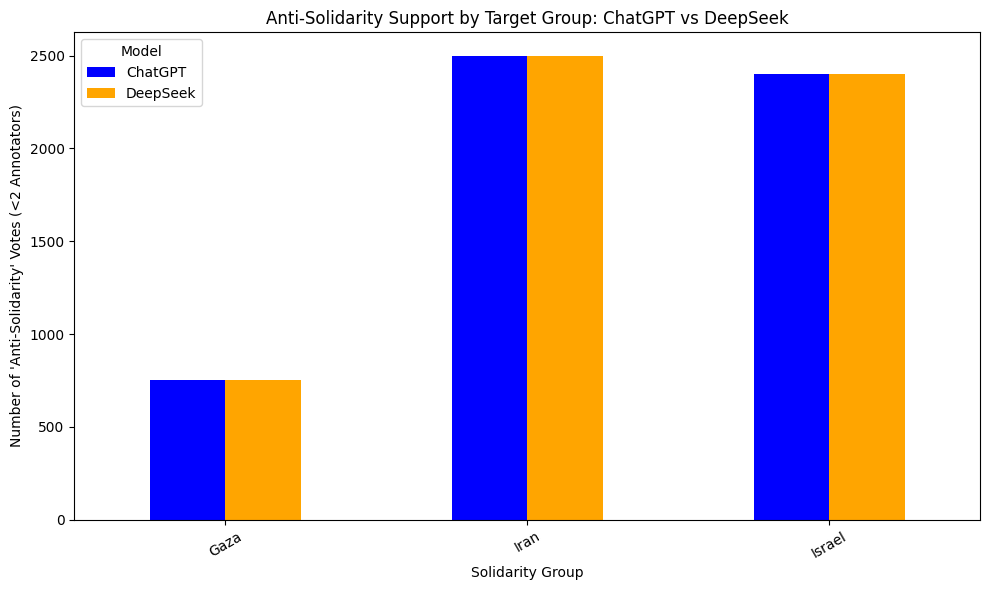

In [13]:
# === Chart 2: Anti-Solidarity only ===
df_compare['anti_chatgpt'] = 1 - df_compare['answer_chatgpt']
df_compare['anti_deepseek'] = 1 - df_compare['answer_deepseek']
anti_plot = df_compare.groupby('solidarity_group')[['anti_chatgpt', 'anti_deepseek']].sum()
anti_plot.plot(kind='bar', figsize=(10, 6), color=['blue', 'orange'])
plt.title("Anti-Solidarity Support by Target Group: ChatGPT vs DeepSeek")
plt.xlabel("Solidarity Group")
plt.ylabel("Number of 'Anti-Solidarity' Votes (<2 Annotators)")
plt.legend(["ChatGPT", "DeepSeek"], title="Model")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

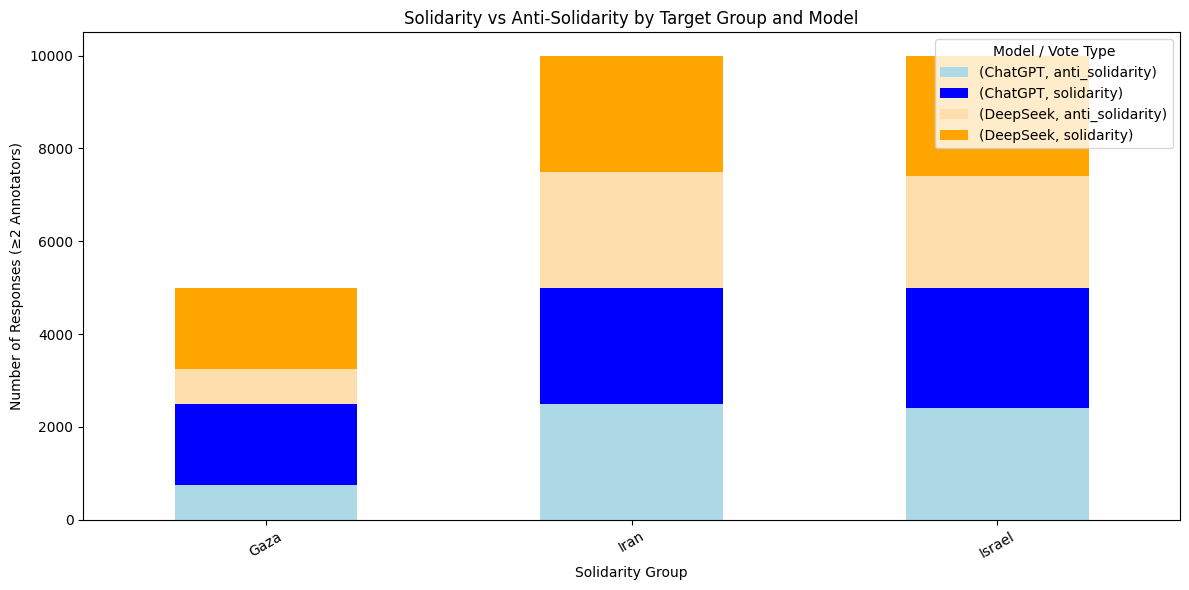

In [14]:

# === Chart 3: Stacked Bar (Both) ===
def get_grouped_vote_counts(df, model_col, group_col='solidarity_group'):
    counts = df.groupby([group_col, model_col]).size().unstack(fill_value=0)
    for label in [0, 1]:
        if label not in counts.columns:
            counts[label] = 0
    return counts[[0, 1]].rename(columns={0: 'anti_solidarity', 1: 'solidarity'})

chatgpt_counts = get_grouped_vote_counts(df_compare, 'answer_chatgpt')
deepseek_counts = get_grouped_vote_counts(df_compare, 'answer_deepseek')

chatgpt_counts.columns = pd.MultiIndex.from_product([['ChatGPT'], chatgpt_counts.columns])
deepseek_counts.columns = pd.MultiIndex.from_product([['DeepSeek'], deepseek_counts.columns])

combined = pd.concat([chatgpt_counts, deepseek_counts], axis=1)

combined.plot(kind='bar', stacked=True, figsize=(12, 6), color={
    ('ChatGPT', 'solidarity'): 'blue',
    ('ChatGPT', 'anti_solidarity'): 'lightblue',
    ('DeepSeek', 'solidarity'): 'orange',
    ('DeepSeek', 'anti_solidarity'): 'navajowhite'
})
plt.title("Solidarity vs Anti-Solidarity by Target Group and Model")
plt.xlabel("Solidarity Group")
plt.ylabel("Number of Responses (≥2 Annotators)")
plt.legend(title="Model / Vote Type", loc='upper right')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()